In [10]:
# 读取数据
import time
import pandas as pd #数据分析
import matplotlib.pyplot as plt
import numpy as np
#混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
time_start=time.time()
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)

#去重
# import matplotlib.pyplot as plt
# IsDuplicated=data.duplicated()
#
# IsDuplicated.value_counts().plot(kind='bar')
# plt.show()
data_1=data.drop_duplicates()

#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
# dummies_service = pd.get_dummies(data_1["service"], prefix='service')
# data_2 = pd.concat([data_1, dummies_protocol,dummies_flag,dummies_service], axis=1)
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
feature_selection=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_access_files",
    "num_outbound_cmds","is_guest_login","rerror_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR",
    "flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_3=data_2[feature_selection]
y_3=data_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop."]
probe=["satan.","portsweep.","ipsweep.","nmap."]
for i in u2r:
    y_3[y_3==i]='U2R' #u2r
for i in r2l:
    y_3[y_3==i]='R2L' #r2l
for i in dos:
    y_3[y_3==i]='DOS'  #dos
for i in probe:
    y_3[y_3==i]='Probing' #probe
y_3[y_3=="normal."]='Normal' #normal
y_3=np.array(y_3)  #变成array格式，一维
#baseline
#标准化
from sklearn.preprocessing import StandardScaler
scaler_base=StandardScaler().fit(X_3)
X_b=scaler_base.transform(X_3)  #X是ndarray，二维

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_b,y_3,test_size=0.2,random_state=0)  #切分样本
#分类器
from sklearn.ensemble import RandomForestClassifier
##建立模型
weight={'Normal':1,'DOS':1,'Probing':5,'R2L':8,'U2R':100}
clf_1 = RandomForestClassifier(n_estimators=100,class_weight='balanced')

#学习曲线
import numpy as np
from sklearn.model_selection import learning_curve
train_sizes,train_scores,test_scores=learning_curve(estimator=clf_1,
                                X=X_train,y=y_train,
                                train_sizes=np.linspace(0.05,1,10),
                                 cv=10, n_jobs=1,random_state=0)
train_mean=np.mean(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_std=np.std(train_scores,axis=1)

#验证测试样本
clf_1.fit(X_train,y_train)
preditions_base=clf_1.predict(X_test)

In [11]:
clf_1

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

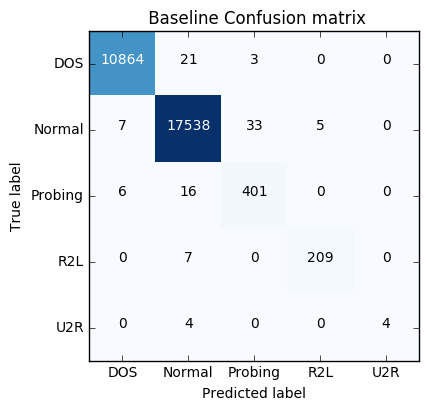

 Baseline
[ 0.99238399  0.99248711  0.9924785   0.9938178   0.99590444  0.99647115
  0.99636812  0.99644538  0.99647113  0.99656558]
             precision    recall  f1-score   support

        DOS   0.998805  0.997796  0.998300     10888
     Normal   0.997271  0.997441  0.997356     17583
    Probing   0.917620  0.947991  0.932558       423
        R2L   0.976636  0.967593  0.972093       216
        U2R   1.000000  0.500000  0.666667         8

avg / total   0.996535  0.996497  0.996489     29118

--------------------------------------------------------------------------------


In [12]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,preditions_base)
class_names=['DOS','Normal','Probing','R2L','U2R']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title=' Baseline Confusion matrix')
plt.show()
#分类报告
from sklearn.metrics import classification_report
class_names=['DOS','Normal','Probing','R2L','U2R']
print(" Baseline")
print(test_mean)
print(classification_report(y_test,preditions_base,target_names=class_names,digits=6))
print("--------------------------------------------------------------------------------")

###########################################################################

In [ ]:
F1 [ 0.76430167  0.83203426  0.81529779  0.83581817  0.85301369  0.87037016
  0.89157948  0.88322556  0.87629     0.8746277   0.86690248  0.88798783
  0.8699709   0.8818697   0.87989962  0.87902588  0.88852094  0.88644534
  0.89822216  0.88619065]
Precison [ 0.84397767  0.87181966  0.93919204  0.87197454  0.92841614  0.91940086
  0.90725196  0.96079284  0.94832294  0.97424257  0.93763409  0.93667666
  0.93658358  0.97022529  0.9193942   0.98049177  0.95131546  0.95175241
  0.95712145  0.95441218]
Recall [ 0.75195969  0.78998676  0.79476607  0.80882212  0.82633557  0.83309631
  0.82898056  0.85106294  0.84761227  0.84382714  0.84343839  0.84906749
  0.86375065  0.8574967   0.85019742  0.85733441  0.86927166  0.85676001
  0.87157823  0.86038481]